In [25]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os,sys,time
import numpy as np
import pandas as pd
import pymaster as nmt
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from   IPython.display import clear_output
from matplotlib import cm
from matplotlib import rc
from copy import deepcopy as dcopy
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)
#############################################
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation/beam_analyzes/scripts')
#import beam_modelling         as model
import handling_data          as hdata

# mask

In [2]:
def getmaps_simple(pathmaps, mapsname):
    pathmaps = os.path.join(pathmaps, mapsname)
    with fits.open(pathmaps) as h:
        maps = h[0].data
    return maps

def getmaps_foregrounds(dir_foregrounds = None, bin_= None):
    if bin_!=None:
        AME  = getmaps_simple(dir_foregrounds,"psm_ame_rot_mK.fits")[bin_]
        CMB  = getmaps_simple(dir_foregrounds,"psm_cmb_rot_mK.fits")[bin_]
        FRPS = getmaps_simple(dir_foregrounds,"psm_frps_rot_mK.fits")[bin_]
        FREE = getmaps_simple(dir_foregrounds,"psm_free_rot_mK.fits")[bin_]
        SYNC = getmaps_simple(dir_foregrounds,"psm_synch_rot_mK.fits")[bin_]
    else:
        AME  = getmaps_simple(dir_foregrounds,"psm_ame_rot_mK.fits")
        CMB  = getmaps_simple(dir_foregrounds,"psm_cmb_rot_mK.fits")
        FRPS = getmaps_simple(dir_foregrounds,"psm_frps_rot_mK.fits")
        FREE = getmaps_simple(dir_foregrounds,"psm_free_rot_mK.fits")
        SYNC = getmaps_simple(dir_foregrounds,"psm_synch_rot_mK.fits")
    TOTAL = AME+CMB+FRPS+FREE+SYNC
    FG   = {"total": TOTAL,
            "cmb":   CMB,
            "frps":  FRPS,
            "ame":   AME,
            "ff":  FREE,
            "synch": SYNC
            }    
    return FG



In [3]:
dir_mask   = "/media/BINGODATA1/ComponentSeparation/MAPS/PAPER/MASK"
name_mask  = "Mask_tot256.fits"
mask_bingo = getmaps_simple(pathmaps=dir_mask,
                            mapsname=name_mask)

#mask_bingo[mask_bingo<=0]=hp.UNSEEN

In [4]:

def radec_mask(ra_all=None, dec_all=None, ra_min=None, ra_max=None, dec_min=None, dec_max=None):
    pix_dec = np.where((dec_all<dec_max)*(dec_all>dec_min))[0]
    if (ra_min<0) and (ra_max<0):
        ramax  = np.amax((ra_min, ra_max))+360
        ramin  = np.amin((ra_min, ra_max))+360
        pix_ra = np.where((ra_all<=ramax)*(ra_all>=ramin))[0]    
    elif (ra_min*ra_max)<0:    
        ramax = np.amax((ra_min, ra_max))
        ramin = np.amin((ra_min, ra_max))+360
        pix_ra1 = np.where((ra_all<ramax))[0]
        pix_ra2 = np.where((ra_all<=360)*(ra_all>=ramin))[0]
        pix_ra  = np.union1d(pix_ra1, pix_ra2)
    else:
        ramax = np.amax((ra_min, ra_max))
        ramin = np.amin((ra_min, ra_max))
        pix_ra = np.where((ra_all<=ramax)*(ra_all>=ramin))[0] 
    return np.intersect1d(pix_dec, pix_ra)

In [5]:
dec_min = -25.48
dec_max = -10.17
ra_min  = 30
ra_max  = 120
###
nside = 256
npix  = 12*nside**2 
ra,dec = hp.pix2ang(nside, lonlat=True,ipix=np.arange(npix))
###
pixs = radec_mask(ra_all=ra, dec_all=dec, ra_min=ra_min, ra_max=ra_max, dec_min=dec_min, dec_max=dec_max)
nmask = np.zeros(npix)
mask  = np.zeros(npix)
nmask[np.arange(npix)]=hp.UNSEEN
nmask[pixs] =1
mask[pixs]  =1

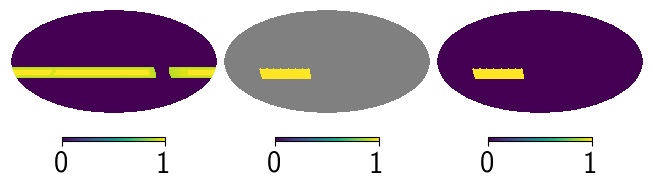

In [6]:
hp.mollview(mask_bingo, norm='hist', sub=131, title=None , max=1, min=0)
hp.mollview(nmask     , norm='hist', sub=132, title=None, max=1, min=0)
hp.mollview(mask      , norm='hist', sub=133, title=None , max=1, min=0)

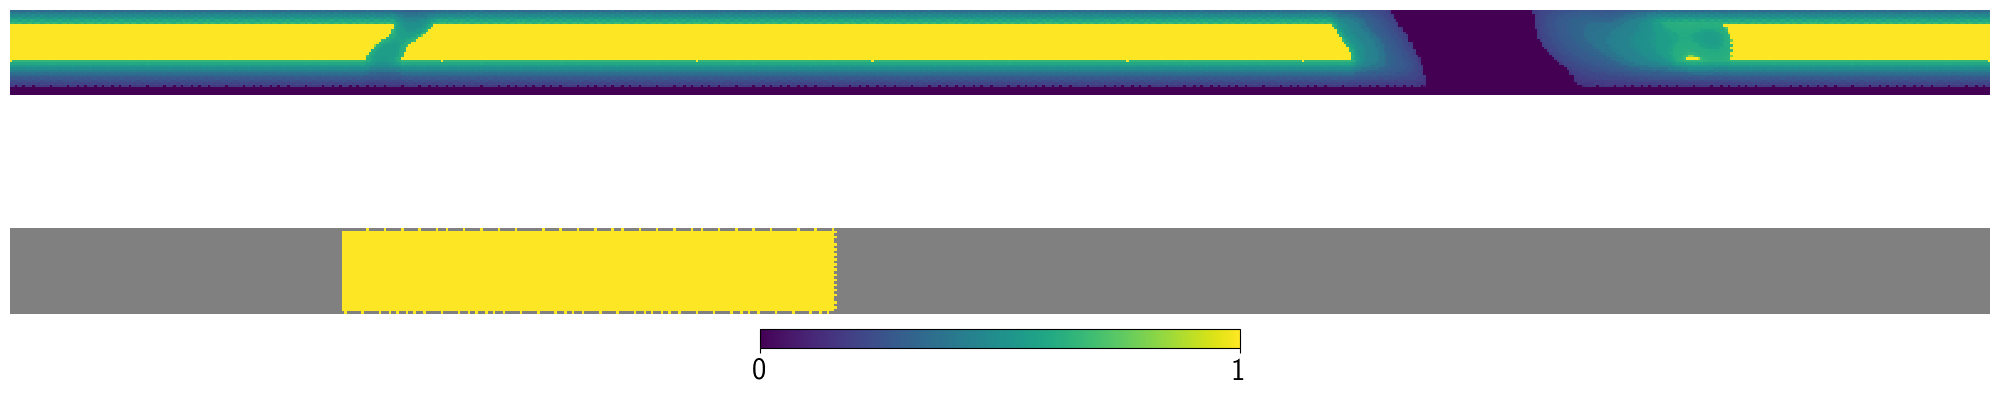

In [7]:
plt.figure(figsize=(20,4))

Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "viridis"

hp.cartview(mask_bingo, norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=211, max=1, min=0, cbar=None)
hp.cartview(nmask     , norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=212, max=1, min=0, 
           )#cbar=None)

#fig   = plt.gcf()
#ax    = plt.gca()
#image = ax.get_images()[0]
#cbar  = fig.colorbar(image, ax=ax, pad=0.1, orientation='horizontal')

plt.figure(figsize=(20,8))

Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "viridis"

hp.cartview(mask      , norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=411, max=1, min=0, cbar=None)
hp.cartview(mask_C1   , norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=412, max=1, min=0, cbar=None)
hp.cartview(mask_C2   , norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=413, max=1, min=0, cbar=None)
hp.cartview(mask_Sm   , norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, sub=414, max=1, min=0) 


# New mask

### 1) determine the swath region

In [9]:
dec_min    = -25.282 #from hitmap
dec_max    =  -9.897
nside      = 256
npix       = 12*nside**2 
ra,dec     = hp.pix2ang(nside, lonlat=True,ipix=np.arange(npix))
pixs       = np.where((dec<dec_max)*(dec>dec_min))[0]
mask       = np.zeros(npix)
mask[pixs] = 1

In [10]:
dir_foregrounds = "/media/BINGODATA1/ComponentSeparation/MAPS/PAPER/PSM_Components"
FG = getmaps_foregrounds(dir_foregrounds=dir_foregrounds)
fg = dcopy(FG['total'][0])
perc_fg_excl = 0.20 #20% more intense pixels removed
npix = hp.get_map_size(fg)
n2remove = int(npix*perc_fg_excl)
#n2remove/hp.get_map_size(fg)
sort_fg = np.flip(np.sort(fg))[:n2remove]
idex = np.array([])
for isort in sort_fg:
    ide = np.where(fg==isort)[0]
    idex = np.hstack((idex,ide))
    idex = np.int64(idex)


idex = np.int64(idex)
nidex = idex[:n2remove]
fg[nidex]=hp.UNSEEN

In [11]:
#nside = hp.npix2nside(npix)
mask_gal = np.ones(npix)
mask_gal[nidex]=0

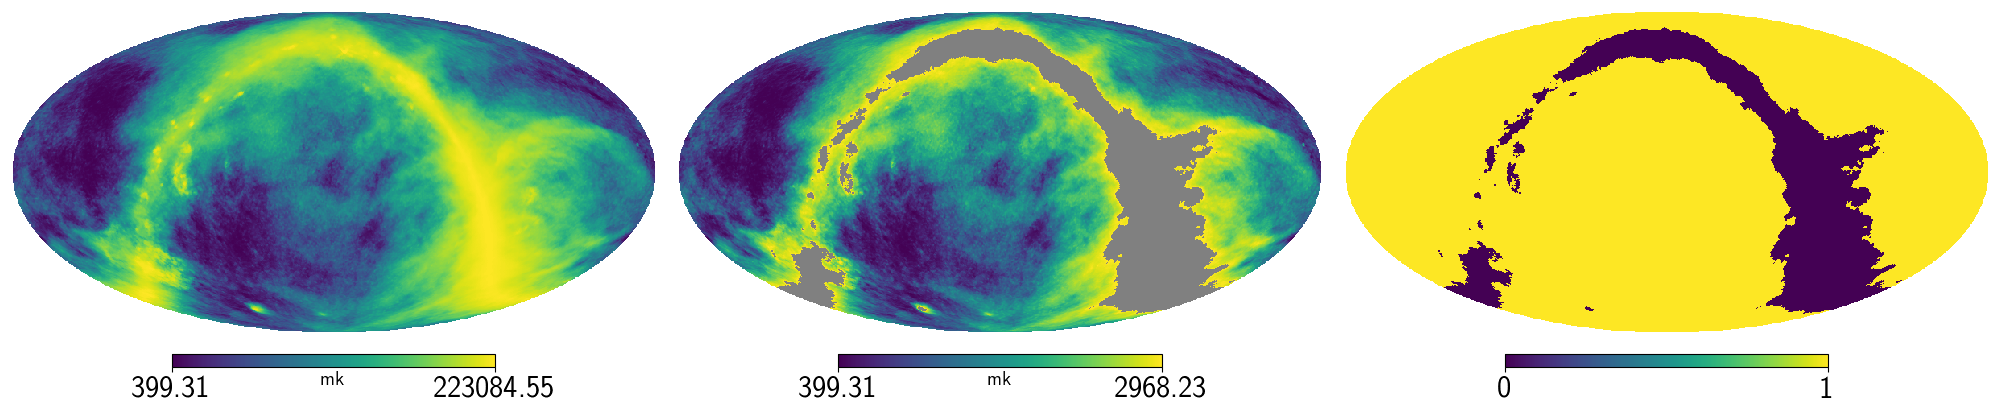

In [12]:
plt.figure(figsize=(20,4))
hp.mollview(FG['total'][0], norm='hist', title=None, sub=131, unit='mk', format='%.2f')
hp.mollview(fg, norm='hist', title=None, sub=132, unit='mk', format='%.2f')
hp.mollview(mask_gal, norm='hist', title=None, sub=133)
#plt.savefig("/home/amarins/FG_cut.jpg", dpi=100, bbox_inches='tight')

### 3) build the boundary smoothed mask

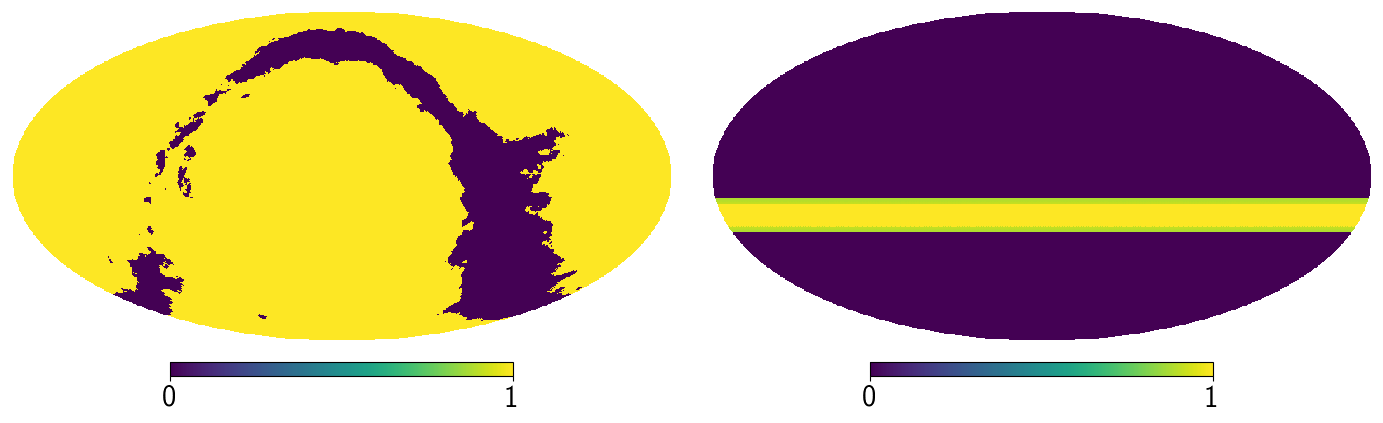

In [13]:
aposcale = 2.5 #5% of apodization with C2
mask_C2 = nmt.mask_apodization(mask, aposcale, apotype="C2")

plt.figure(figsize=(14,4))
hp.mollview(mask_gal, norm='hist', title=None, sub=121)
hp.mollview(mask_C2, norm='hist', title=None, sub=122)


In [14]:
aposcale = 5
new_mask = dcopy(mask)
new_mask[nidex]=0
new_mask  = nmt.mask_apodization(new_mask, aposcale, apotype="C2")

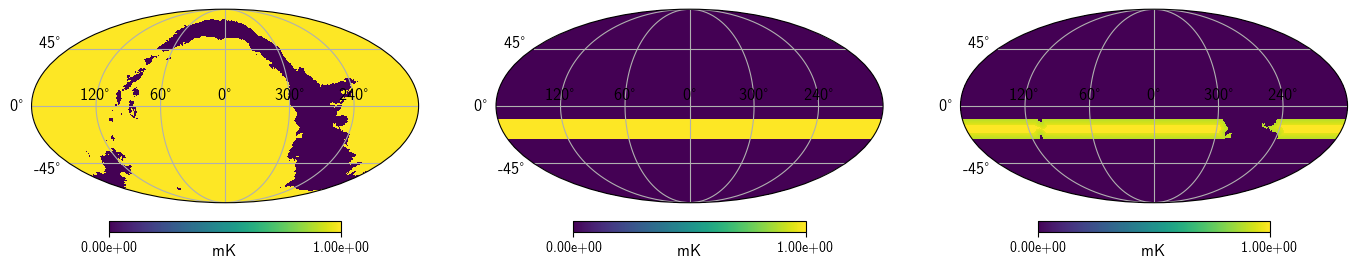

In [15]:
plot_params = {'norm':'hist','cmap':'viridis','title':None,'format':'%.2e','unit':'mK'}
plt.figure(figsize=(14,4))
imaps = [mask_gal,mask, new_mask]
for j ,imap in enumerate(imaps):
    hpn.projview(imap, 
                     norm   = plot_params['norm'], 
                     cmap   = plot_params['cmap'], 
                     title  = plot_params['title'], 
                     format = plot_params['format'],
                     unit   = plot_params['unit'],
                     sub = (1,len(imaps),j+1),
                     graticule=True,
                     graticule_labels=True,
                     latitude_grid_spacing=45
                   )
#plt.savefig("/home/amarins/combining_masks.jpg", dpi=100, bbox_inches='tight')

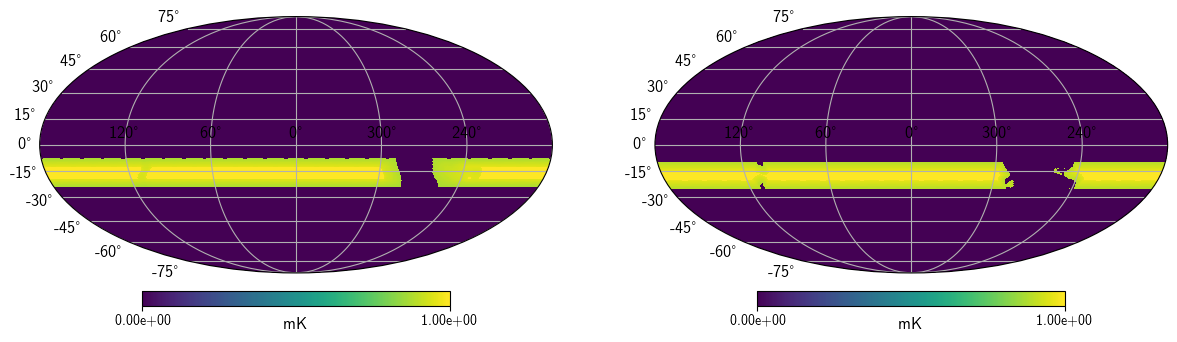

In [16]:
plot_params = {'norm':'hist','cmap':'viridis','title':None,'format':'%.2e','unit':'mK'}
plt.figure(figsize=(12,4))
imaps = [mask_bingo, new_mask]
for j ,imap in enumerate(imaps):
    hpn.projview(imap, 
                     norm   = plot_params['norm'], 
                     cmap   = plot_params['cmap'], 
                     title  = plot_params['title'], 
                     format = plot_params['format'],
                     unit   = plot_params['unit'],
                     sub = (1,len(imaps),j+1),
                     graticule=True,
                     graticule_labels=True,
                     latitude_grid_spacing=15
                   )
#plt.savefig("/home/amarins/old_new_masks°.jpg", dpi=100, bbox_inches='tight')

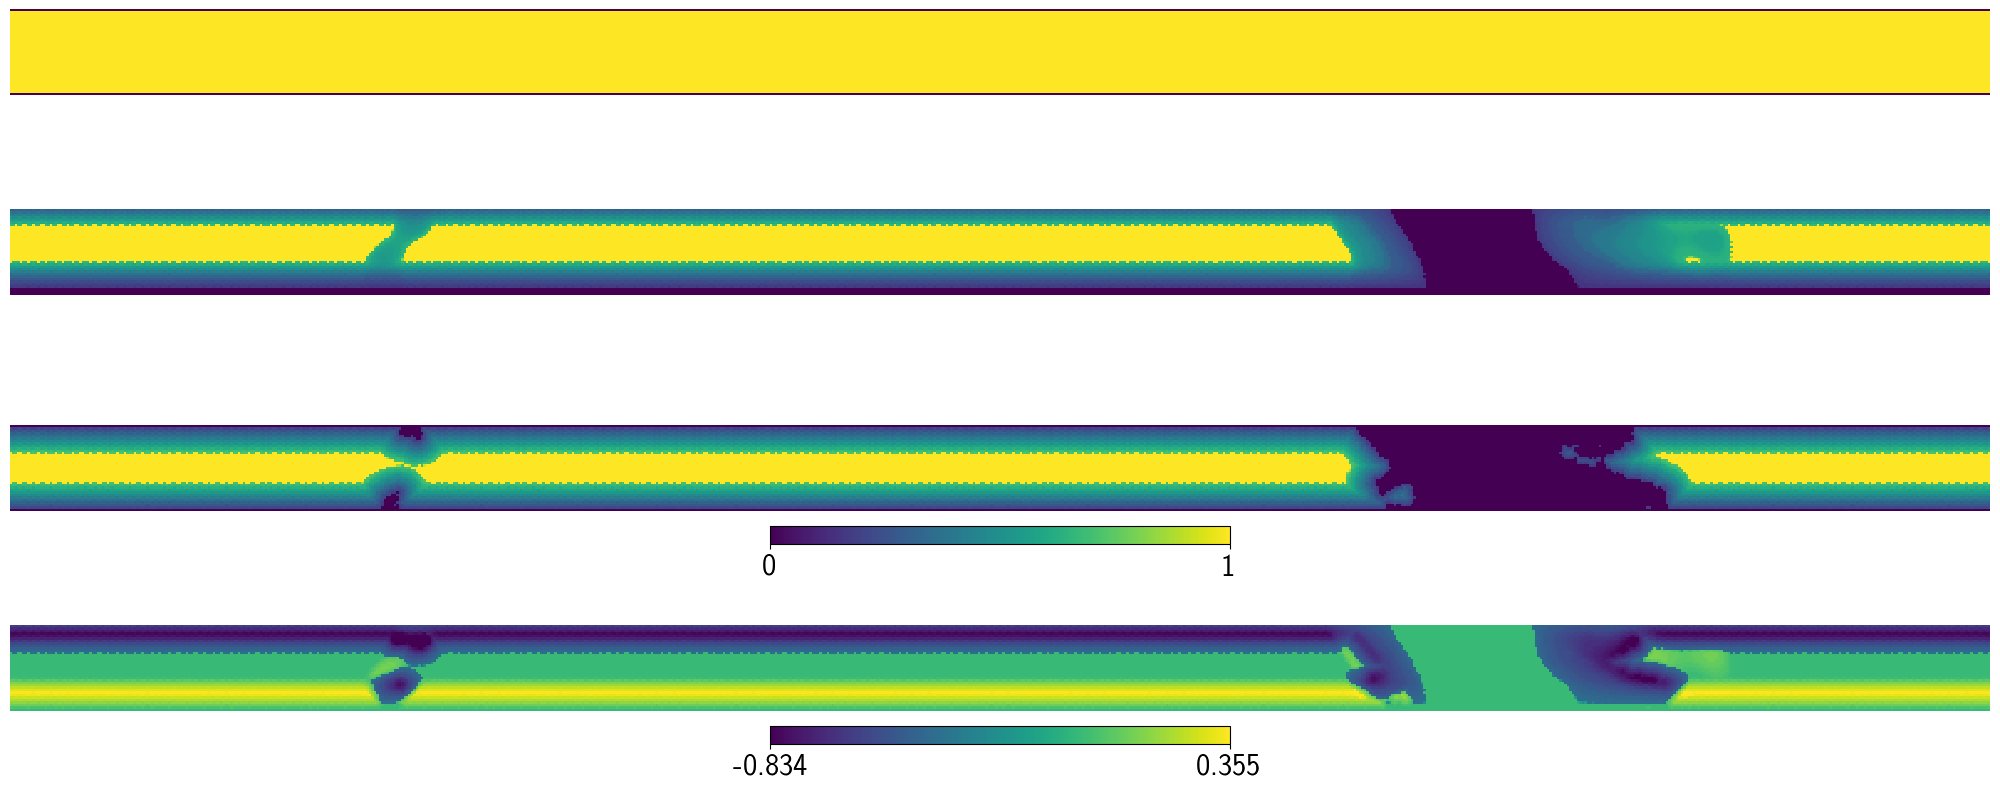

In [17]:
plt.figure(figsize=(20,8))

Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "viridis"

hp.cartview(mask   , norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, 
            sub=411, cbar=None)
hp.cartview(mask_bingo      , norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, 
            sub=412, cbar=None)
hp.cartview(new_mask   , norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, 
            sub=413)
hp.cartview(new_mask-mask_bingo, norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, 
            sub=414)
#plt.savefig("/home/amarins/masksHIDE&SEEK hitmap to determine the sky region .jpg", dpi=100, bbox_inches='tight')

### 4) Summary

In [18]:
### parameters
dec_min    = -25.282 #from hitmap
dec_max    =  -9.897
nside      = 512
aposcale   = 5      #boundary apodization degree
dir_foregrounds = "/media/BINGODATA1/ComponentSeparation/MAPS/PAPER/PSM_Components"
perc_fg_excl = 0.20 #percentage of more intense pixels removed
output_info = {
               "pathdir_FG" :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/FG512',
               "nameFG"     :'FG_I_512_980mhz1260mhz_30bins_full_L0.fits'
              }

In [19]:
FG = hdata.getmap(dirpath_ =output_info['pathdir_FG'], 
                  filename_=output_info['nameFG'], 
                  healpix_readingformat=False, hdu=1)

In [20]:
# first mask -- BINGO sky region
npix       = 12*nside**2 
ra,dec     = hp.pix2ang(nside, lonlat=True,ipix=np.arange(npix))
pixs       = np.where((dec<dec_max)*(dec>dec_min))[0]
mask       = np.zeros(npix)
mask[pixs] = 1
# second mask -- galactic mask
#FG         = getmaps_foregrounds(dir_foregrounds=dir_foregrounds)
#fg         = dcopy(FG['total'][0]) #more intense
FG = hdata.getmap(dirpath_ =output_info['pathdir_FG'], 
                  filename_=output_info['nameFG'], 
                  healpix_readingformat=False, hdu=1)
fg         = dcopy(FG[0]) #more intense
npix       = hp.get_map_size(fg)
n2remove   = int(npix*perc_fg_excl)
sort_fg    = np.flip(np.sort(fg))[:n2remove]
idex       = np.array([])
for isort in sort_fg:
    ide  = np.where(fg==isort)[0]
    idex = np.hstack((idex,ide))
    idex = np.int64(idex)
idex  = np.int64(idex)
nidex = idex[:n2remove]
# combining first and second masks and apodizing the boundary
try:
    del new_mask
except:
    pass
new_mask        = dcopy(mask)
new_mask[nidex] = 0
new_mask        = nmt.mask_apodization(new_mask, aposcale, apotype="C2")

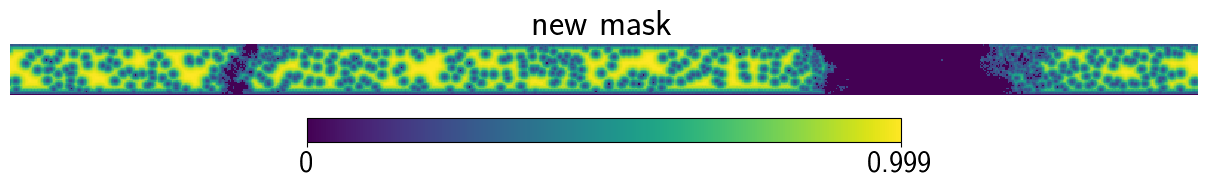

In [21]:
plt.figure(figsize=(12,3))

Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "viridis"
hp.cartview(new_mask , 
            norm="hist", unit=None,  
            latra=[Dec_min,Dec_max], 
            cmap=CMAP, title='new mask',
            sub=111)

### Saving the new mask

In [27]:
output_info = {'type':'mask',
               'nside': 512,
               'dec':{'min': -25.48, 'max': -10.17},
               'ra':{'min':  None, 'max': None},
               'foreground_cut':True, 'perc_foreground_cut': 0.5,
               'apodization'   :False, 'apod_scale':0.5,'apod_type':'C2',
               "pathdir_FG"    :'/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/FG256',
               "nameFG"        :'FG_I_256_980mhz1260mhz_30bins_full_nonfrps_L0.fits',
               'output_dir'    :"/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/M256",
               'add_info'      : 'test'
              }

In [28]:
mname = hdata.return_new_FITSfilename_mask(output_info)

In [29]:
hdr_hdu0  = hdata.creating_primary_FITSheader_mask()
vec_hdu1  = hdata.building_mask(output_info) #mask
hdr_hdu1  = hdata.creating_mask_FITSheader(output_info) #Header to be used 

hdu0 = fits.PrimaryHDU(header=hdr_hdu0)
hdu1 = fits.ImageHDU(header=hdr_hdu1,data=vec_hdu1, name="MASK")
hdul = fits.HDUList([hdu0,hdu1])
if output_info['output_dir']==None:
    filename = os.path.join(os.getcwd()              , mname)
else:
    filename = os.path.join(output_info['output_dir'], mname)
if output_info['output_dir']==None:
    hdata.file_verification(os.getcwd(),"","outputs")
    pathout = os.path.join(os.getcwd(),"outputs")
else:
    pathout = output_info['output_dir']    
hdul.writeto(filename,overwrite=True)

In [31]:
def save_FITS_newformat_mask(output_info=None):
    mname    = return_new_FITSfilename_mask(output_info)
    hdr_hdu0 = creating_primary_FITSheader_mask()
    vec_hdu1 = building_mask(output_info) #mask
    hdr_hdu1 = creating_mask_FITSheader(output_info) #Header to be used 

    hdu0 = fits.PrimaryHDU(header=hdr_hdu0)
    hdu1 = fits.ImageHDU(header=hdr_hdu1,data=vec_hdu1, name="MASK")
    hdul = fits.HDUList([hdu0,hdu1])
    if output_info['output_dir']==None:
        filename = os.path.join(os.getcwd()              , mname)
    else:
        filename = os.path.join(output_info['output_dir'], mname)
    if output_info['output_dir']==None:
        hdata.file_verification(os.getcwd(),"","outputs")
        pathout = os.path.join(os.getcwd(),"outputs")
    else:
        pathout = output_info['output_dir']   
    print('Filename {}'.format(mname))
    print('Saving in {}'.format(pathout))
    hdul.writeto(filename,overwrite=True)
    print('Saved.\n')


In [32]:
dir_mask   = "/media/BINGODATA1/ComponentSeparation/MAPS/HS"
name_mask  = "hitmap_140Horns_1Month.fits"
hitmap     = hdata.getmap(dirpath_=dir_mask, filename_=name_mask, healpix_readingformat=False, hdu=0)
name_mask  = "naivemap_140Horns_1Month.fits"
naivemap   = hdata.getmap(dirpath_=dir_mask, filename_=name_mask, healpix_readingformat=False, hdu=0)

In [33]:
dir_mask   = "/media/BINGODATA1/ComponentSeparation/MAPS/PAPER/PSM_Components"
name_mask  = "psm_ame_rot_mK.fits"
amemap     = hdata.getmap(dirpath_=dir_mask, filename_=name_mask, 
                            healpix_readingformat=False, hdu=0)
amemap = amemap[0]#hp.ud_grade(amemap[0],hp.get_nside(naivemap))

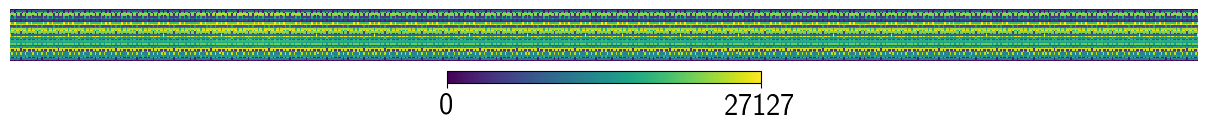

In [34]:
plt.figure(figsize=(12,4))
dec_min    = -25.282 #from hitmap
dec_max    =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "viridis"

hp.cartview(hitmap , norm="hist", unit=None,  
            latra=[Dec_min,Dec_max], 
            cmap=CMAP, title=None,format="%d",
            sub=311)

plt.savefig("/home/amarins/{}.jpg".format("hitmap_HS"), dpi=100, bbox_inches='tight')            ;

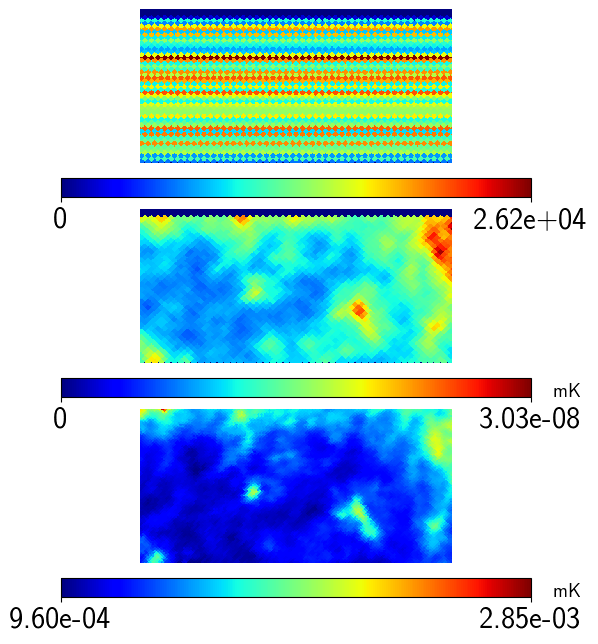

In [36]:
plt.figure(figsize=(12,6))
dec_min    = -25.282 #from hitmap
dec_max    =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 1
Ra_min  = 0 - 33.333333333333336/2
Ra_max  = 0 + 33.333333333333336/2
CMAP    = "jet"


hp.cartview(hitmap , unit=None,  latra=[Dec_min,Dec_max],  lonra=[Ra_min,Ra_max], 
            cmap=CMAP, title=None , sub=311)
hp.cartview(naivemap ,  latra=[Dec_min,Dec_max],  lonra=[Ra_min,Ra_max], unit="mK",
            cmap=CMAP, title=None , sub=312)
hp.cartview(amemap , 
            latra=[Dec_min,Dec_max], 
            lonra=[Ra_min,Ra_max],             
            cmap=CMAP, title=None,unit="mK", 
            sub=313, format="%.2e")

plt.savefig("/home/amarins/{}.jpg".format("naive_hit"), dpi=100, bbox_inches='tight')            ;

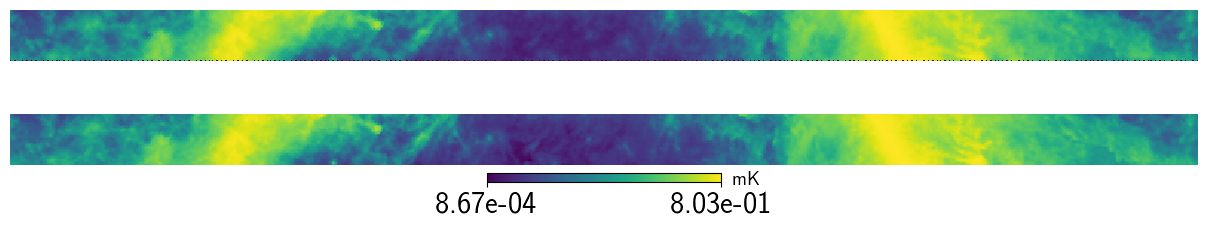

In [37]:
plt.figure(figsize=(12,3))
dec_min    = -25.282 #from hitmap
dec_max    =  -9.897
Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "viridis"

hp.cartview(naivemap , norm="hist", unit=None,  
            latra=[Dec_min,Dec_max], 
            cmap=CMAP, title=None,cbar=None,
            sub=311)
hp.cartview(amemap , norm="hist", unit='mK',  
            latra=[Dec_min,Dec_max], 
            cmap=CMAP, title=None, format="%.2e",
            sub=312)

#plt.savefig("/home/amarins/{}.jpg".format("naive_ame"), dpi=100, bbox_inches='tight')  

### ---------------------------

In [38]:
dir_mask       = "/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/M256"

name_mask_0apd = ["mask_256_10fgcut.fits",
                  "mask_256_20fgcut.fits",
                  "mask_256_30fgcut.fits",
                  "mask_256_50fgcut.fits",
                  "mask_256_70fgcut.fits"]

name_mask_1apd = ["mask_256_1degC2apod_10fgcut.fits",
                  "mask_256_1degC2apod_20fgcut.fits",
                  "mask_256_1degC2apod_30fgcut.fits",
                  "mask_256_1degC2apod_50fgcut.fits",
                  "mask_256_1degC2apod_70fgcut.fits"]
name_mask_3apd = ["mask_256_3degC2apod_10fgcut.fits",
                  "mask_256_3degC2apod_20fgcut.fits",
                  "mask_256_3degC2apod_30fgcut.fits",
                  "mask_256_3degC2apod_50fgcut.fits",
                  "mask_256_3degC2apod_70fgcut.fits"]
name_mask_5apd = ["mask_256_5degC2apod_10fgcut.fits",
                  "mask_256_5degC2apod_20fgcut.fits",
                  "mask_256_5degC2apod_30fgcut.fits",
                  "mask_256_5degC2apod_50fgcut.fits",
                  "mask_256_5degC2apod_70fgcut.fits"]


mask_0apd  = {'10%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_0apd[0], healpix_readingformat=False, hdu=1),
              '20%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_0apd[1], healpix_readingformat=False, hdu=1),
              '30%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_0apd[2], healpix_readingformat=False, hdu=1),
              '50%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_0apd[3], healpix_readingformat=False, hdu=1),
              '70%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_0apd[4], healpix_readingformat=False, hdu=1)}

mask_1apd  = {'10%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_1apd[0], healpix_readingformat=False, hdu=1),
              '20%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_1apd[1], healpix_readingformat=False, hdu=1),
              '30%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_1apd[2], healpix_readingformat=False, hdu=1),
              '50%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_1apd[3], healpix_readingformat=False, hdu=1),
              '70%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_1apd[4], healpix_readingformat=False, hdu=1)}

mask_3apd  = {'10%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_3apd[0], healpix_readingformat=False, hdu=1),
              '20%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_3apd[1], healpix_readingformat=False, hdu=1),
              '30%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_3apd[2], healpix_readingformat=False, hdu=1),
              '50%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_3apd[3], healpix_readingformat=False, hdu=1),
              '70%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_3apd[4], healpix_readingformat=False, hdu=1)}

mask_5apd  = {'10%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_5apd[0], healpix_readingformat=False, hdu=1),
              '20%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_5apd[1], healpix_readingformat=False, hdu=1),
              '30%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_5apd[2], healpix_readingformat=False, hdu=1),
              '50%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_5apd[3], healpix_readingformat=False, hdu=1),
              '70%':hdata.getmap(dirpath_=dir_mask, filename_=name_mask_5apd[4], healpix_readingformat=False, hdu=1)}

0deg apodization


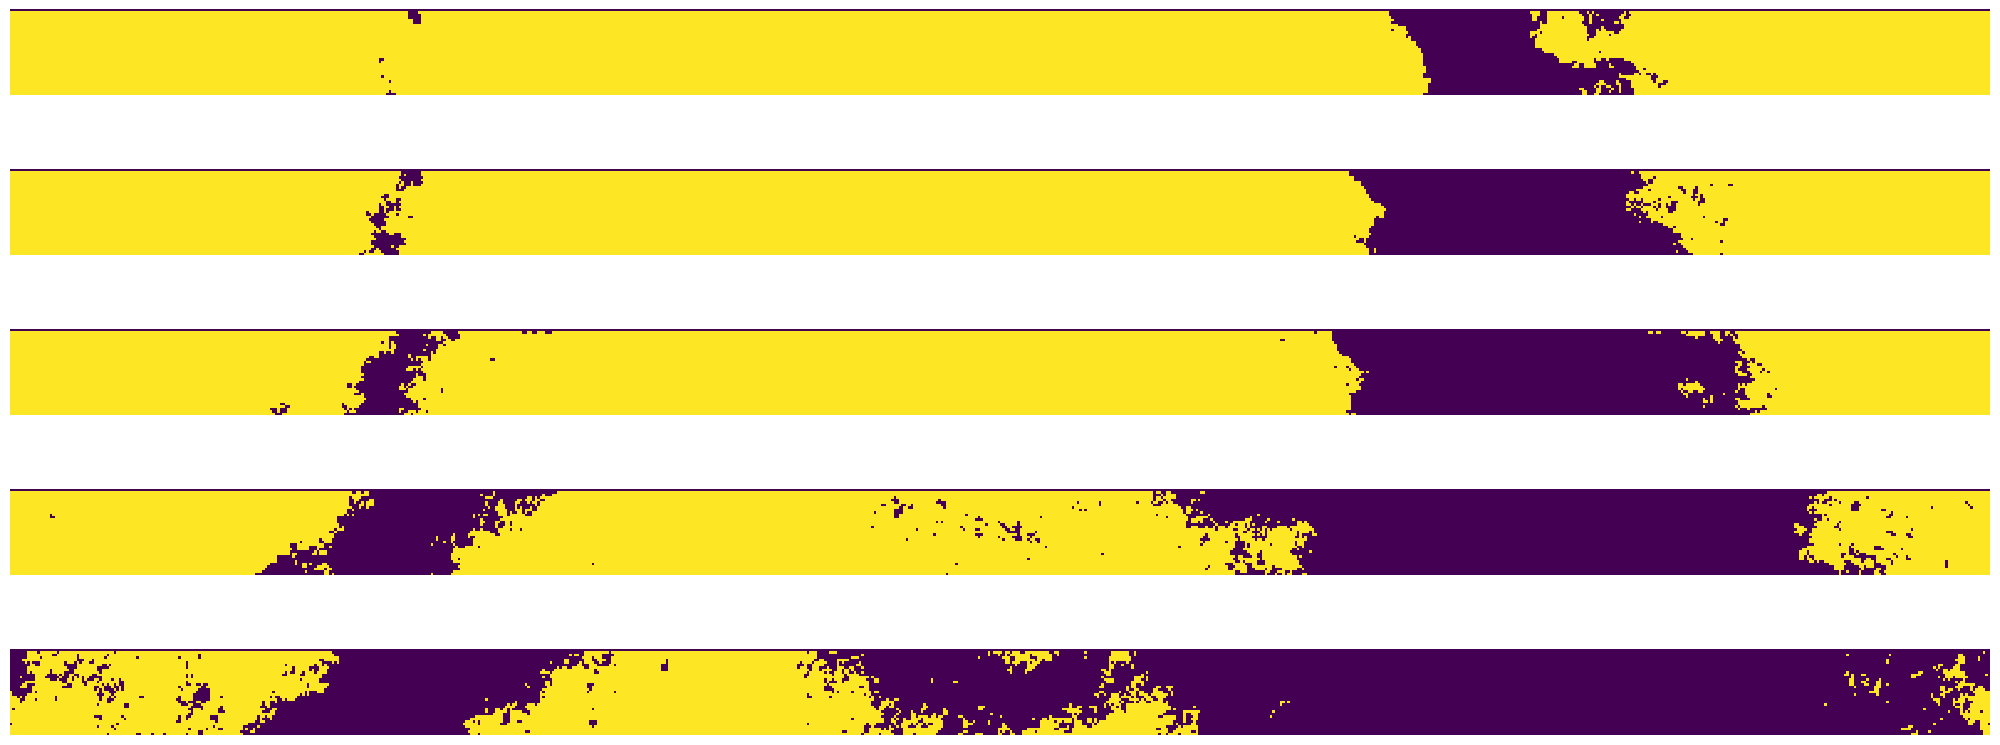

In [39]:
plt.figure(figsize=(20,8))

Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "viridis"
print("0deg apodization")
for i, (iperc, ipos) in enumerate(zip(["10%","20%","30%","50%","70%"],[511,512,513,514,515])):
    hp.cartview(mask_0apd[iperc], norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,sub=ipos, cbar=None)

1deg apodization


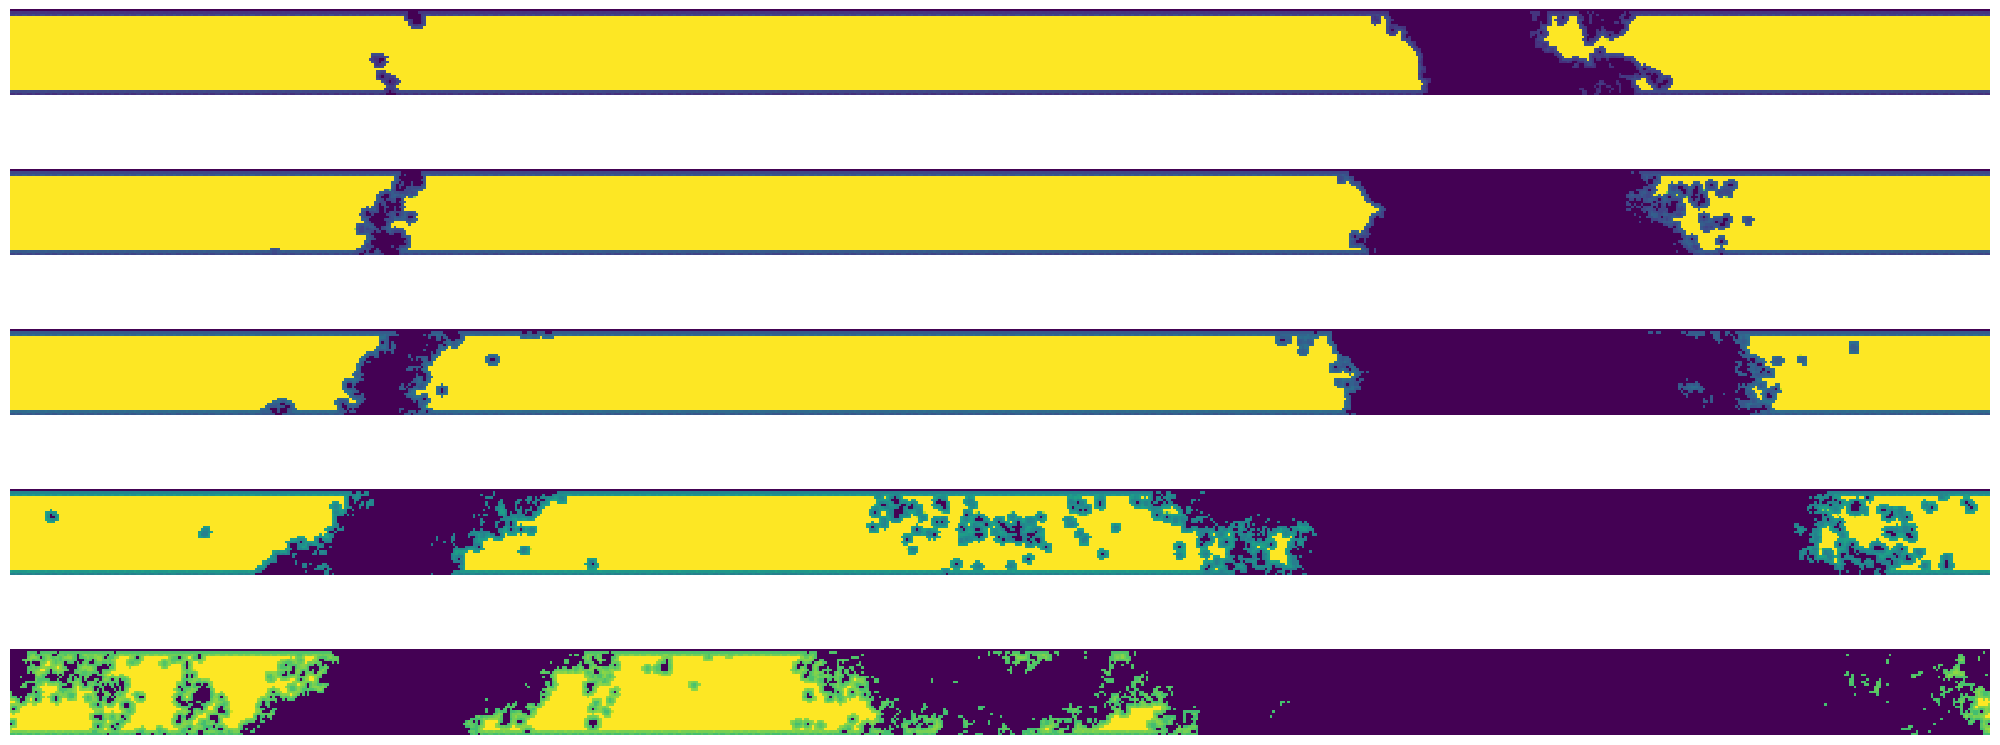

In [40]:
plt.figure(figsize=(20,8))

Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "viridis"
print("1deg apodization")
for i, (iperc, ipos) in enumerate(zip(["10%","20%","30%","50%","70%"],[511,512,513,514,515])):
    hp.cartview(mask_1apd[iperc], norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,sub=ipos, cbar=None)

3deg apodization


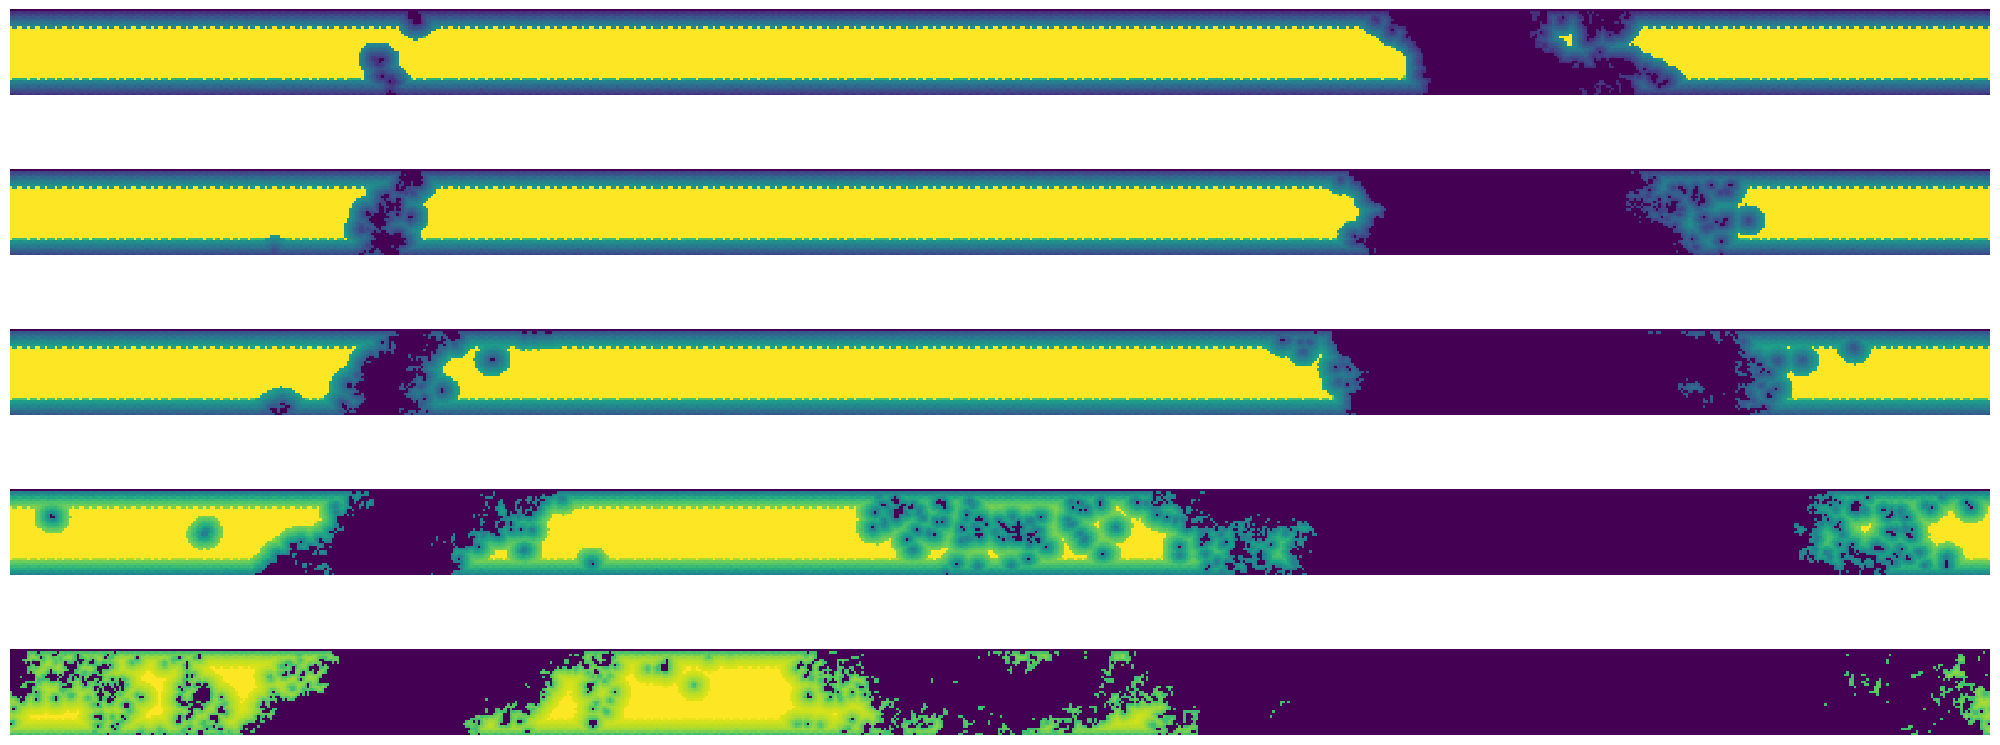

In [41]:
plt.figure(figsize=(20,8))

Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "viridis"
print("3deg apodization")
for i, (iperc, ipos) in enumerate(zip(["10%","20%","30%","50%","70%"],[511,512,513,514,515])):
    hp.cartview(mask_3apd[iperc], norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,sub=ipos, cbar=None)

5deg apodization


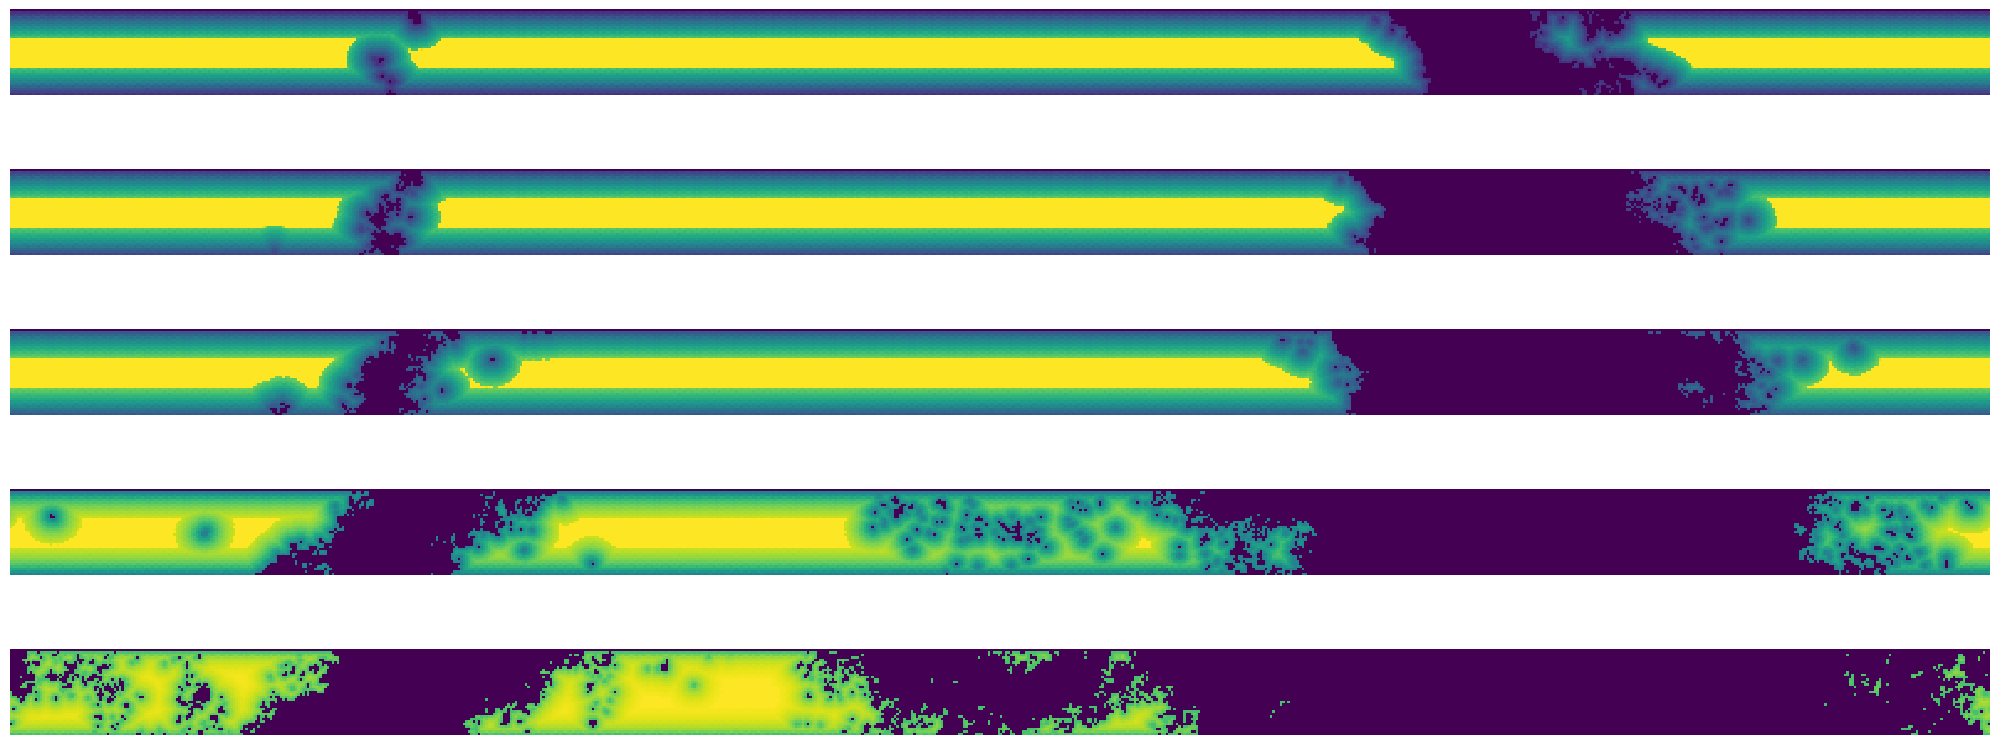

In [42]:
plt.figure(figsize=(20,8))

Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "viridis"
print("5deg apodization")
for i, (iperc, ipos) in enumerate(zip(["10%","20%","30%","50%","70%"],[511,512,513,514,515])):
    hp.cartview(mask_5apd[iperc], norm="hist", unit=None,  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,sub=ipos, cbar=None)

In [43]:
dir_foregrounds = "/media/BINGODATA1/ComponentSeparation/MAPS/PAPER/PSM_Components"
FG = getmaps_foregrounds(dir_foregrounds=dir_foregrounds)
fg = dcopy(FG['total'][10])

In [44]:
for i, iname in enumerate(mask_0apd.keys()):
    m = dcopy(mask_0apd[iname])
    _cl_ = hp.anafast(fg*m, pol=False)
    if not i:
        cl_M0apd = {iname:_cl_}
    else:
        cl_M0apd[iname] = _cl_


for i, iname in enumerate(mask_1apd.keys()):
    m = dcopy(mask_1apd[iname])
    _cl_ = hp.anafast(fg*m, pol=False)
    if not i:
        cl_M1apd = {iname:_cl_}
    else:
        cl_M1apd[iname] = _cl_

for i, iname in enumerate(mask_3apd.keys()):
    m = dcopy(mask_3apd[iname])
    _cl_ = hp.anafast(fg*m, pol=False)
    if not i:
        cl_M3apd = {iname:_cl_}
    else:
        cl_M3apd[iname] = _cl_

for i, iname in enumerate(mask_5apd.keys()):
    m = dcopy(mask_5apd[iname])
    _cl_ = hp.anafast(fg*m, pol=False)
    if not i:
        cl_M5apd = {iname:_cl_}
    else:
        cl_M5apd[iname] = _cl_

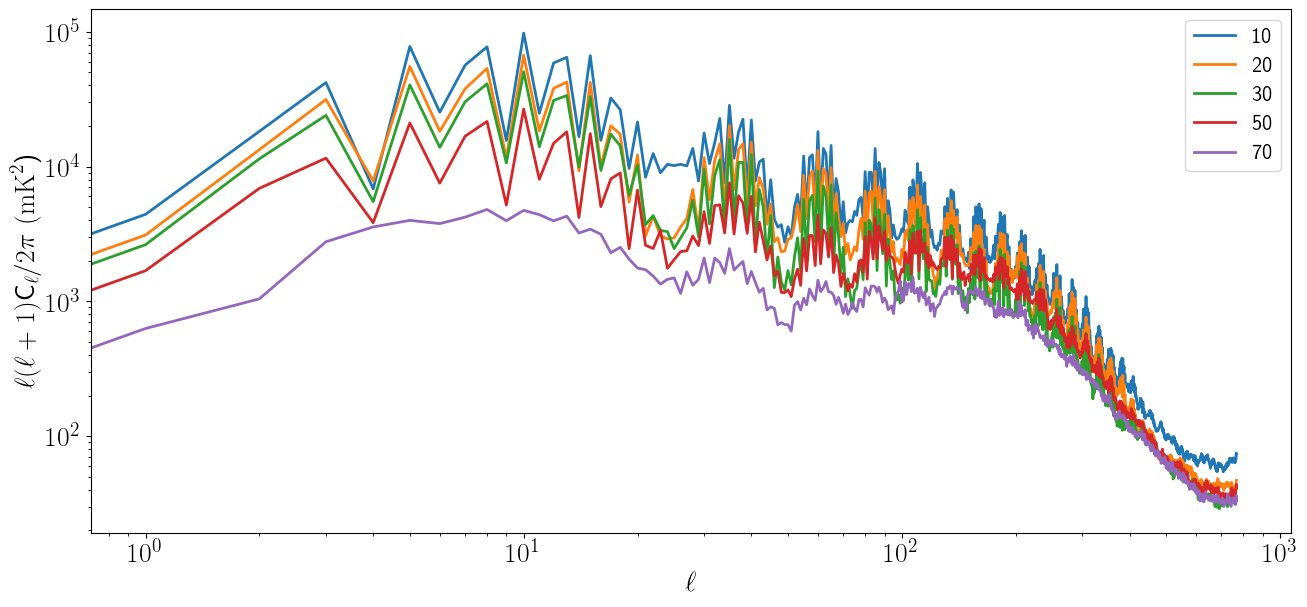

In [46]:
grid  = plt.GridSpec(1,1,top=1.2,right=2)
nu,nl = 30,cl_M1apd[iname].size
l     = np.arange(nl)
fact  = l*(l+1)/(2*np.pi)
L0    = "L{}".format(83)

#for col,i in enumerate(np.random.randint(nu,size=numplots)):
bins = np.array([bin])
plt.title("1% apodized", fontsize=20)
for col,i in enumerate(bins):
    ax = plt.subplot(grid[0,col])
    #print("bin: {}".format(i))
    for iname in cl_M1apd.keys():
        plt.plot( l,fact*cl_M1apd[iname], label=iname, linewidth =2)
    plt.xscale("log")
    plt.yscale("log")
    ax.tick_params(axis='both', which='major', labelsize = 20)
    plt.ylabel(r"$\ell(\ell+1)$C$_{\ell}/2\pi$ $(\textrm{mK}^2$)", fontsize=20)
    plt.xlabel(r"$\ell$", fontsize=20)
    plt.legend(fontsize=15)
#plt.savefig("{}".format() + ".jpg", dpi=100, bbox_inches='tight');

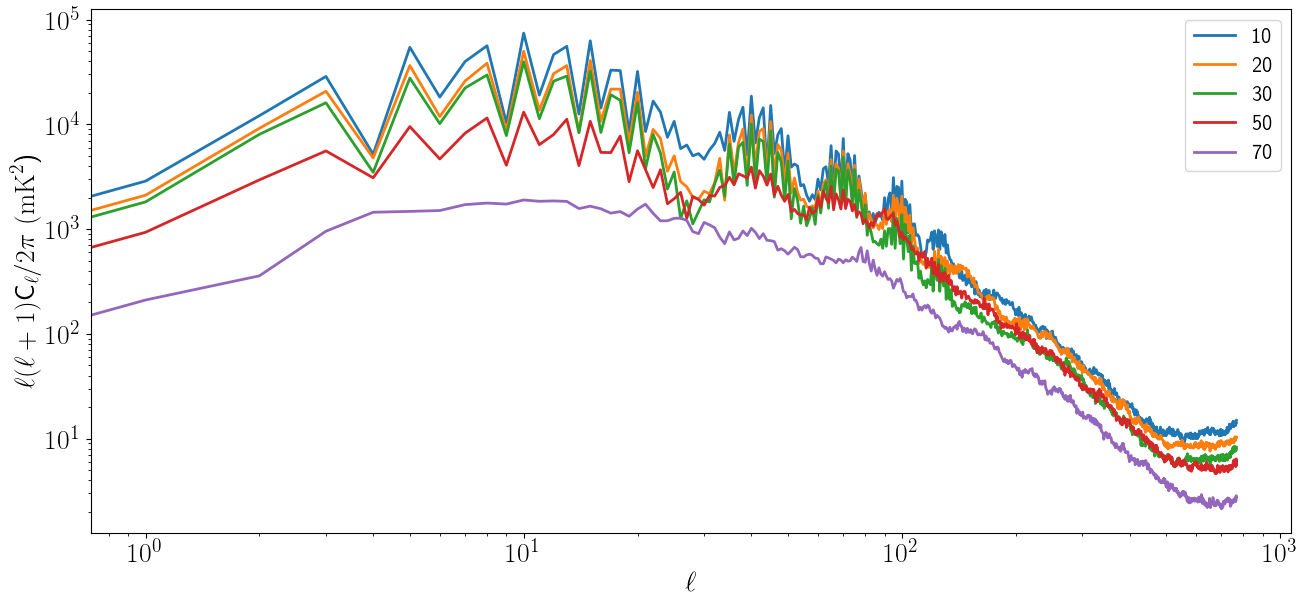

In [47]:
grid  = plt.GridSpec(1,1,top=1.2,right=2)
nu,nl = 30,cl_M1apd[iname].size
l     = np.arange(nl)
fact  = l*(l+1)/(2*np.pi)
L0    = "L{}".format(83)

#for col,i in enumerate(np.random.randint(nu,size=numplots)):
bins = np.array([bin])
plt.title("3% apodized", fontsize=20)
for col,i in enumerate(bins):
    ax = plt.subplot(grid[0,col])
    #print("bin: {}".format(i))
    for iname in cl_M1apd.keys():
        plt.plot( l,fact*cl_M3apd[iname], label=iname, linewidth =2)
    plt.xscale("log")
    plt.yscale("log")
    ax.tick_params(axis='both', which='major', labelsize = 20)
    plt.ylabel(r"$\ell(\ell+1)$C$_{\ell}/2\pi$ $(\textrm{mK}^2$)", fontsize=20)
    plt.xlabel(r"$\ell$", fontsize=20)
    plt.legend(fontsize=15)
#plt.savefig("{}".format() + ".jpg", dpi=100, bbox_inches='tight');

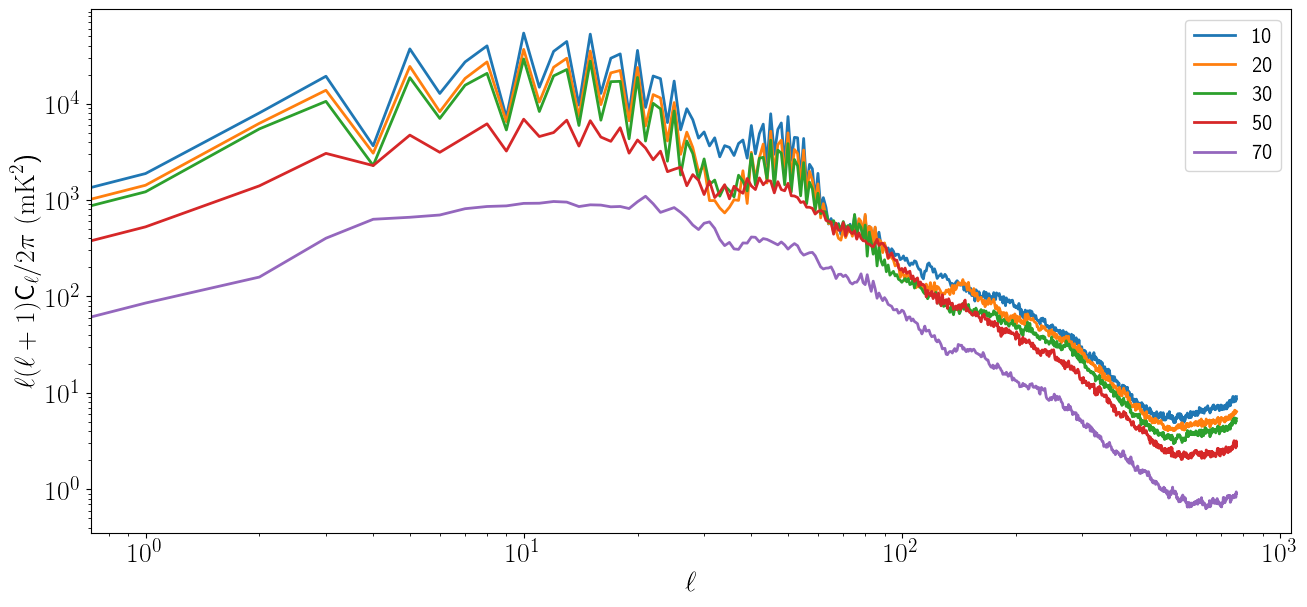

In [48]:
grid  = plt.GridSpec(1,1,top=1.2,right=2)
nu,nl = 30,cl_M1apd[iname].size
l     = np.arange(nl)
fact  = l*(l+1)/(2*np.pi)
L0    = "L{}".format(83)

#for col,i in enumerate(np.random.randint(nu,size=numplots)):
bins = np.array([bin])
plt.title("5% apodized", fontsize=20)
for col,i in enumerate(bins):
    ax = plt.subplot(grid[0,col])
    #print("bin: {}".format(i))
    for iname in cl_M1apd.keys():
        plt.plot( l,fact*cl_M5apd[iname], label=iname, linewidth =2)
    plt.xscale("log")
    plt.yscale("log")
    ax.tick_params(axis='both', which='major', labelsize = 20)
    plt.ylabel(r"$\ell(\ell+1)$C$_{\ell}/2\pi$ $(\textrm{mK}^2$)", fontsize=20)
    plt.xlabel(r"$\ell$", fontsize=20)
    plt.legend(fontsize=15)
#plt.savefig("{}".format() + ".jpg", dpi=100, bbox_inches='tight');

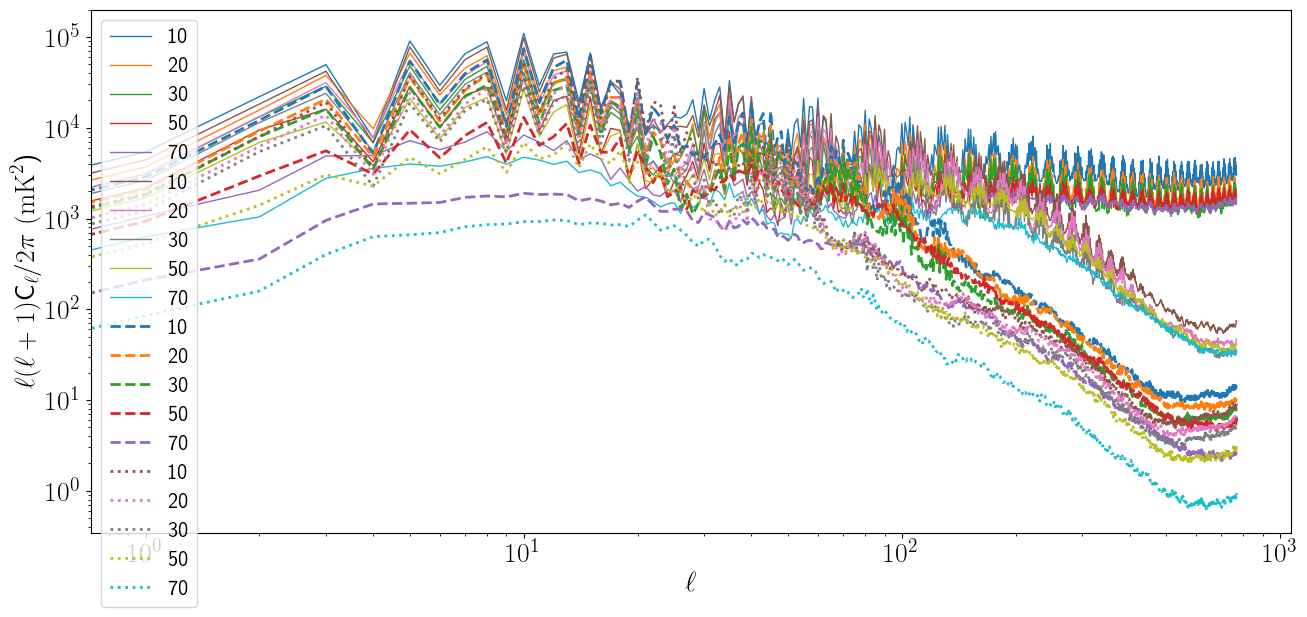

In [49]:
grid  = plt.GridSpec(1,1,top=1.2,right=2)
nu,nl = 30,cl_M1apd[iname].size
l     = np.arange(nl)
fact  = l*(l+1)/(2*np.pi)
L0    = "L{}".format(83)

#for col,i in enumerate(np.random.randint(nu,size=numplots)):
bins = np.array([bin])
for col,i in enumerate(bins):
    ax = plt.subplot(grid[0,col])
    #print("bin: {}".format(i))
    for iname in list(cl_M0apd.keys()):
        plt.plot( l,fact*cl_M0apd[iname], label=iname, linewidth =1, linestyle='solid')    
    for iname in list(cl_M1apd.keys()):
        plt.plot( l,fact*cl_M1apd[iname], label=iname, linewidth =1, linestyle='solid')
    for iname in list(cl_M3apd.keys()):
        plt.plot( l,fact*cl_M3apd[iname], label=iname, linewidth =2, linestyle='dashed')
    for iname in list(cl_M5apd.keys()):
        plt.plot( l,fact*cl_M5apd[iname], label=iname, linewidth =2, linestyle='dotted')    
    plt.xscale("log")
    plt.yscale("log")
    ax.tick_params(axis='both', which='major', labelsize = 20)
    plt.ylabel(r"$\ell(\ell+1)$C$_{\ell}/2\pi$ $(\textrm{mK}^2$)", fontsize=20)
    plt.xlabel(r"$\ell$", fontsize=20)
    plt.legend(fontsize=15)
#plt.savefig("{}".format() + ".jpg", dpi=100, bbox_inches='tight');

In [50]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

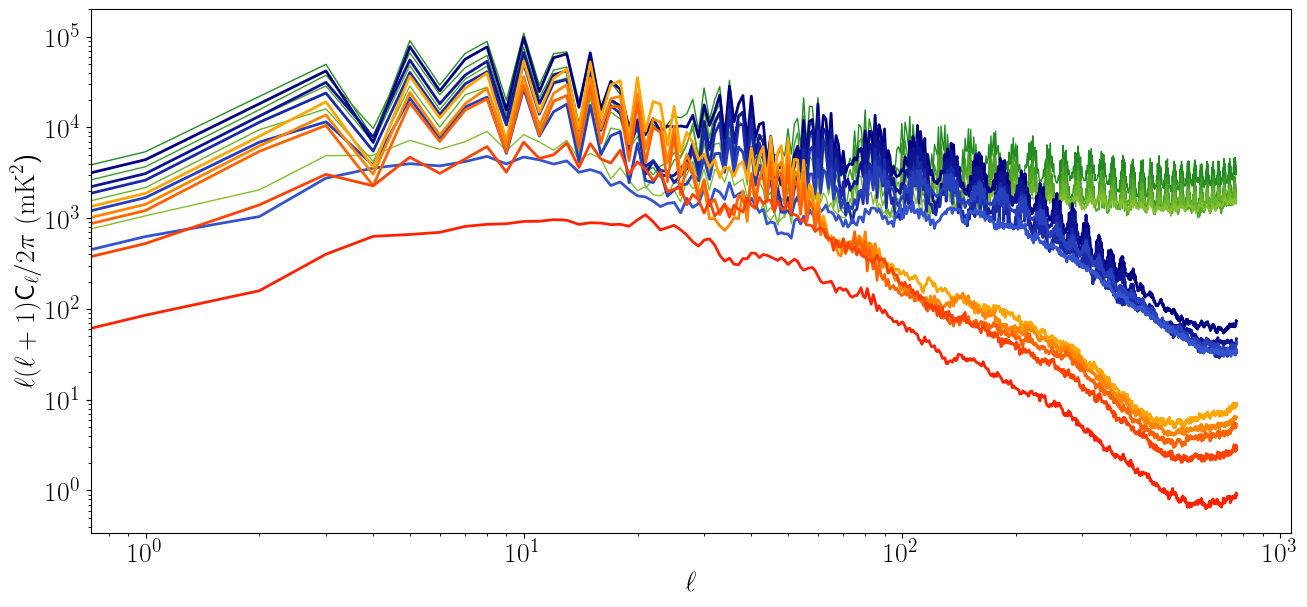

In [52]:
grid  = plt.GridSpec(1,1,top=1.2,right=2)
nu,nl = 30,cl_M1apd[iname].size
l     = np.arange(nl)
fact  = l*(l+1)/(2*np.pi)
L0    = "L{}".format(83)
c = ['forestgreen', 'yellowgreen',
     'navy'  , "royalblue",
     'black' , "bisque",
     "orange", "red"]
n=len(cl_M1apd.keys())
bins = np.array([bin])
for col,i in enumerate(bins):
    ax = plt.subplot(grid[0,col])
    #print("bin: {}".format(i))
    for x,iname in enumerate(list(cl_M0apd.keys())):
        plt.plot( l,fact*cl_M0apd[iname], label=iname, linewidth =1, linestyle='solid' , color=colorFader(c[0],c[1],x/n))  
    for x, iname in enumerate(list(cl_M1apd.keys())):
        plt.plot( l,fact*cl_M1apd[iname], label=iname, linewidth =2, linestyle='solid' , color=colorFader(c[2],c[3],x/n))
    #for x, iname in enumerate(list(cl_M3apd.keys())):
    #    plt.plot( l,fact*cl_M3apd[iname], label=iname, linewidth =2, linestyle='solid', color=colorFader(c[4],c[5],x/n))
    for x, iname in enumerate(list(cl_M5apd.keys())):
        plt.plot( l,fact*cl_M5apd[iname], label=iname, linewidth =2, linestyle='solid', color=colorFader(c[6],c[7],x/n))    
    plt.xscale("log")
    plt.yscale("log")
    ax.tick_params(axis='both', which='major', labelsize = 20)
    plt.ylabel(r"$\ell(\ell+1)$C$_{\ell}/2\pi$ $(\textrm{mK}^2$)", fontsize=20)
    plt.xlabel(r"$\ell$", fontsize=20)
    #plt.legend(fontsize=15)
#plt.savefig("{}".format() + ".jpg", dpi=100, bbox_inches='tight');

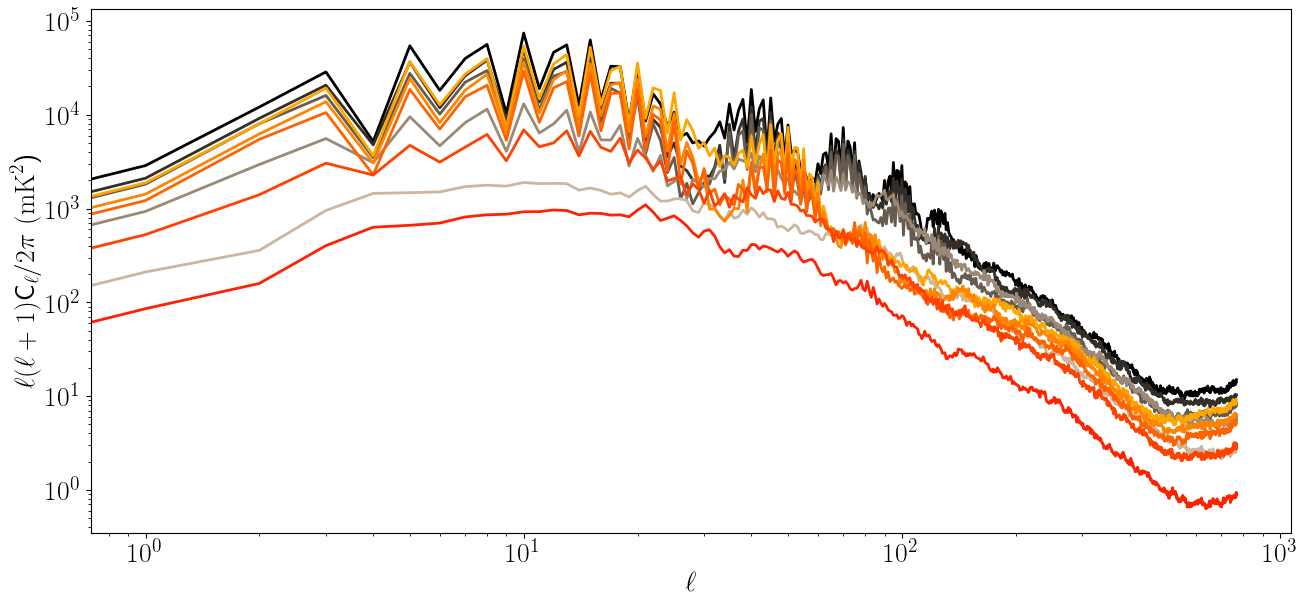

In [53]:
grid  = plt.GridSpec(1,1,top=1.2,right=2)
nu,nl = 30,cl_M1apd[iname].size
l     = np.arange(nl)
fact  = l*(l+1)/(2*np.pi)
L0    = "L{}".format(83)
c = ['navy'  , "royalblue",
     'black' , "bisque",
     "orange", "red"]
n=len(cl_M1apd.keys())
bins = np.array([bin])
for col,i in enumerate(bins):
    ax = plt.subplot(grid[0,col])
    #print("bin: {}".format(i))
    #for x, iname in enumerate(list(cl_M1apd.keys())):
    #    plt.plot( l,fact*cl_M1apd[iname], label=iname, linewidth =2, linestyle='solid' , color=colorFader(c[0],c[1],x/n))
    for x, iname in enumerate(list(cl_M3apd.keys())):
        plt.plot( l,fact*cl_M3apd[iname], label=iname, linewidth =2, linestyle='solid', color=colorFader(c[2],c[3],x/n))
    for x, iname in enumerate(list(cl_M5apd.keys())):
        plt.plot( l,fact*cl_M5apd[iname], label=iname, linewidth =2, linestyle='solid', color=colorFader(c[4],c[5],x/n))    
    plt.xscale("log")
    plt.yscale("log")
    ax.tick_params(axis='both', which='major', labelsize = 20)
    plt.ylabel(r"$\ell(\ell+1)$C$_{\ell}/2\pi$ $(\textrm{mK}^2$)", fontsize=20)
    plt.xlabel(r"$\ell$", fontsize=20)
    #plt.legend(fontsize=15)
#plt.savefig("{}".format() + ".jpg", dpi=100, bbox_inches='tight');

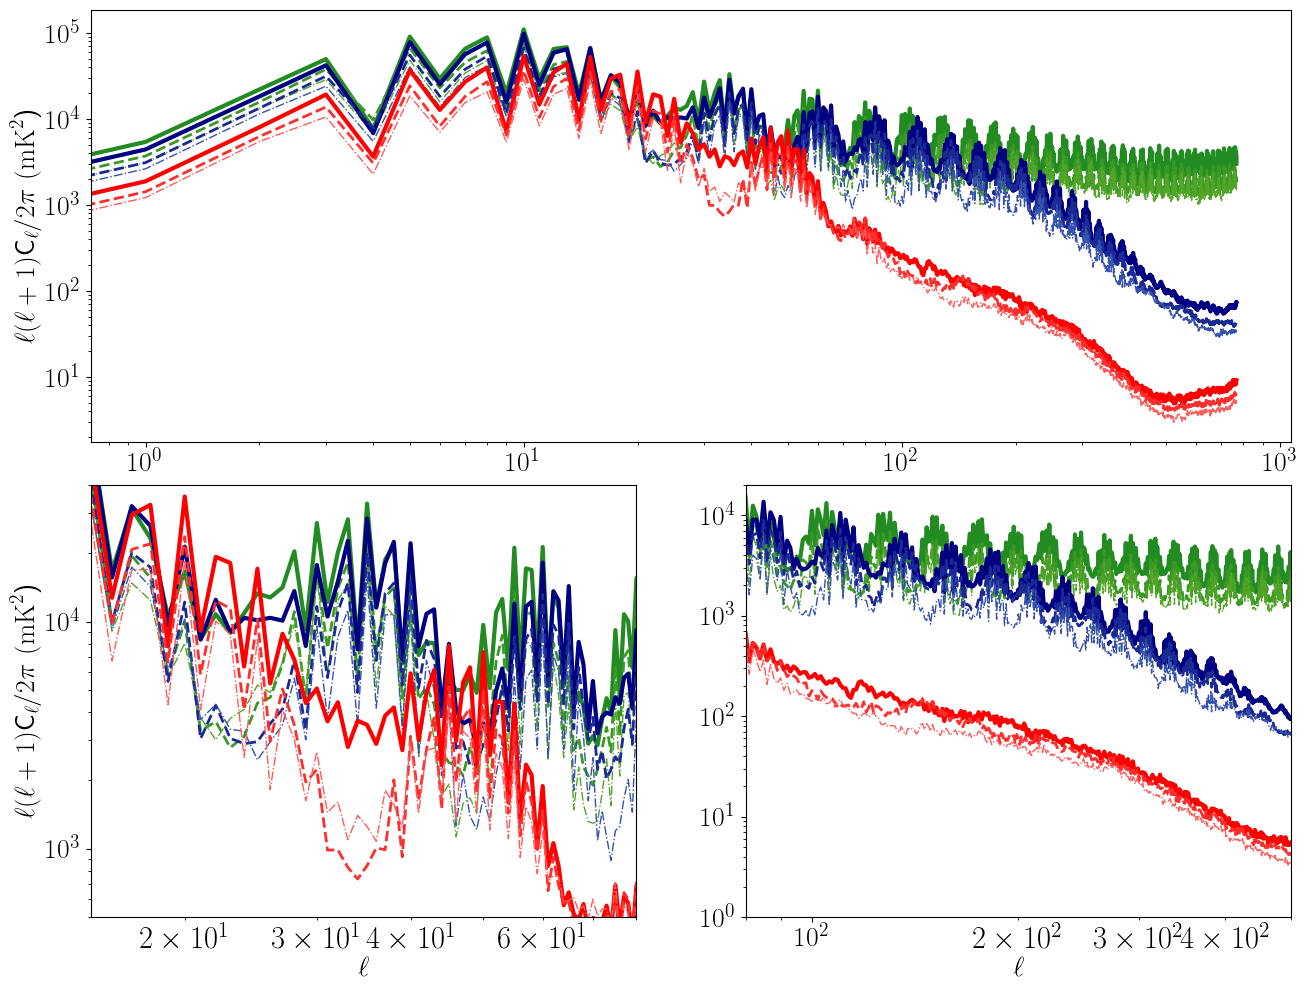

In [56]:
grid  = plt.GridSpec(2,2,top=2*1,right=2,wspace=0.2,hspace=0.1)
nu,nl = 30,cl_M1apd[iname].size
l     = np.arange(nl)
fact  = l*(l+1)/(2*np.pi)
L0    = "L{}".format(83)
c = ['forestgreen', 'yellowgreen',
     'navy'  , "skyblue",
     'black' , "bisque",
     "red", "mistyrose"]

j=3
line_ = [3,2,1]
lstyle = ['solid','dashed','dashdot']
n=len(cl_M1apd.keys())

###########################
ax = plt.subplot(grid[0,:])
#print("bin: {}".format(i))
for x, iname in enumerate(list(cl_M0apd.keys())[:j]):
    plt.plot( l,fact*cl_M0apd[iname], label=iname, linewidth =line_[x], linestyle=lstyle[x], color=colorFader(c[0],c[1],x/n))  
for x, iname in enumerate(list(cl_M1apd.keys())[:j]):
    plt.plot( l,fact*cl_M1apd[iname], label=iname, linewidth =line_[x], linestyle=lstyle[x], color=colorFader(c[2],c[3],x/n))
#for x, iname in enumerate(list(cl_M3apd.keys())[:j]):
#    plt.plot( l,fact*cl_M3apd[iname], label=iname, linewidth =2, linestyle='solid', color=colorFader(c[4],c[5],x/n))
for x, iname in enumerate(list(cl_M5apd.keys())[:j]):
    plt.plot( l,fact*cl_M5apd[iname], label=iname, linewidth =line_[x], linestyle=lstyle[x], color=colorFader(c[6],c[7],x/n))    
plt.xscale("log")
plt.yscale("log")
ax.tick_params(axis='both', which='major', labelsize = 20)
plt.ylabel(r"$\ell(\ell+1)$C$_{\ell}/2\pi$ $(\textrm{mK}^2$)", fontsize=20)
#plt.xlabel(r"$\ell$", fontsize=20)

###########################
for i, (xlim, ylim) in enumerate(zip([[15,80],[80,500]],[[5e2,4e4],[1e0,2e4]])):
    ax = plt.subplot(grid[1,i])
    #print("bin: {}".format(i))
    for x, iname in enumerate(list(cl_M0apd.keys())[:j]):
        plt.plot( l,fact*cl_M0apd[iname], label=iname, linewidth =line_[x], linestyle=lstyle[x], color=colorFader(c[0],c[1],x/n))  
    for x, iname in enumerate(list(cl_M1apd.keys())[:j]):
        plt.plot( l,fact*cl_M1apd[iname], label=iname, linewidth =line_[x], linestyle=lstyle[x], color=colorFader(c[2],c[3],x/n))
    #for x, iname in enumerate(list(cl_M3apd.keys())[:j]):
    #    plt.plot( l,fact*cl_M3apd[iname], label=iname, linewidth =2, linestyle='solid', color=colorFader(c[4],c[5],x/n))
    for x, iname in enumerate(list(cl_M5apd.keys())[:j]):
        plt.plot( l,fact*cl_M5apd[iname], label=iname, linewidth =line_[x], linestyle=lstyle[x], color=colorFader(c[6],c[7],x/n))    
    
    plt.xlim(xlim[0],xlim[1])
    plt.ylim(ylim[0],ylim[1])
    plt.xscale("log")
    plt.yscale("log")
    ax.tick_params(axis='both', which='major', labelsize = 20)
    if not i: plt.ylabel(r"$\ell(\ell+1)$C$_{\ell}/2\pi$ $(\textrm{mK}^2$)", fontsize=20)
    plt.xlabel(r"$\ell$", fontsize=20)


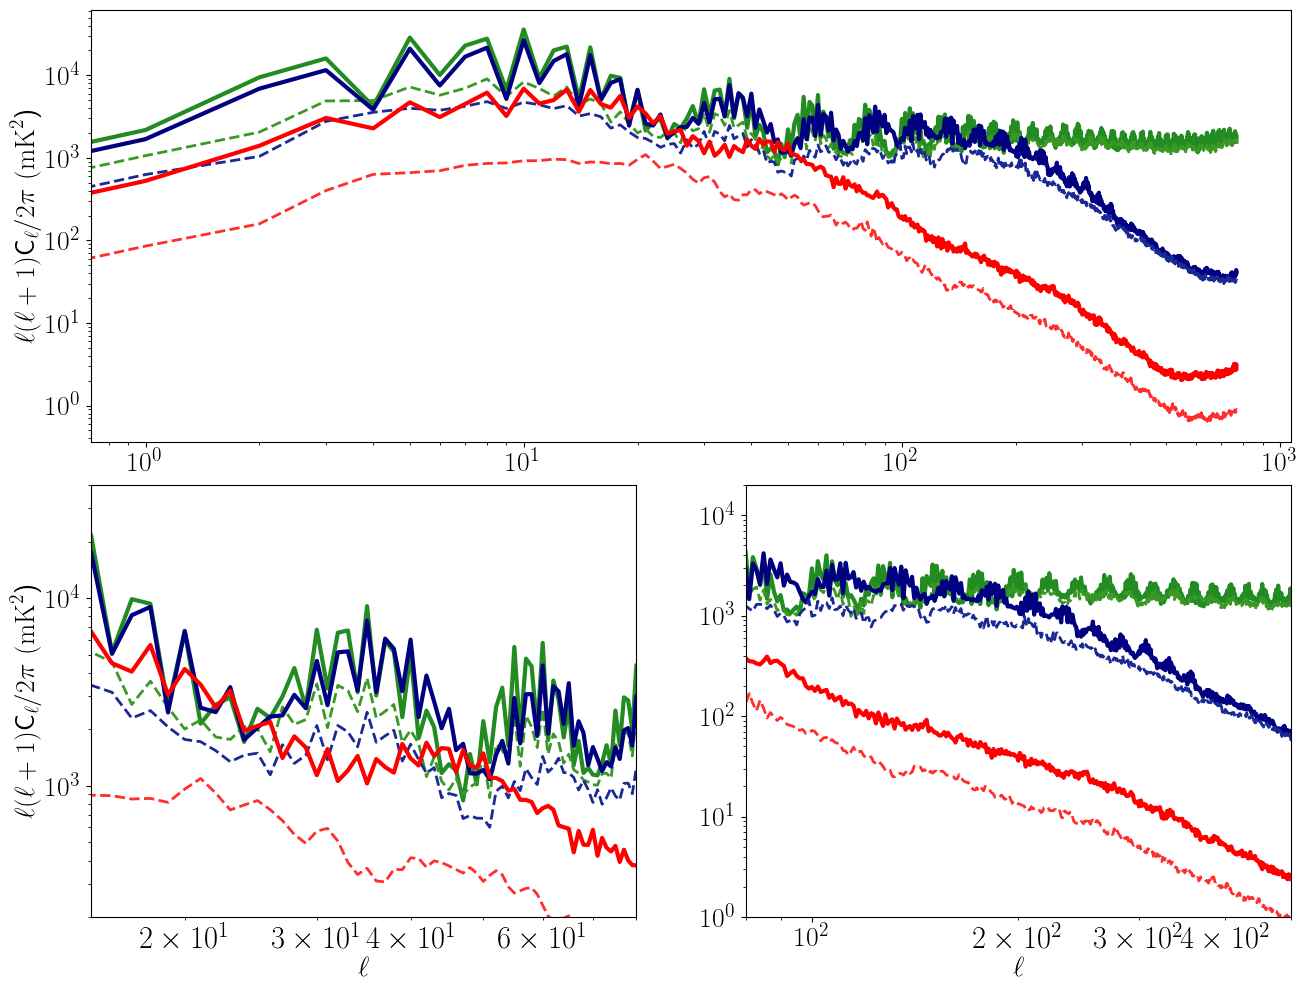

In [55]:
grid  = plt.GridSpec(2,2,top=2*1,right=2,wspace=0.2,hspace=0.1)
nu,nl = 30,cl_M1apd[iname].size
l     = np.arange(nl)
fact  = l*(l+1)/(2*np.pi)
L0    = "L{}".format(83)
c = ['forestgreen', 'yellowgreen',
     'navy'  , "skyblue",
     'black' , "bisque",
     "red", "mistyrose"]

j=3
line_ = [3,2,1]
lstyle = ['solid','dashed','dashdot']
n=len(cl_M1apd.keys())

###########################
ax = plt.subplot(grid[0,:])
#print("bin: {}".format(i))
for x, iname in enumerate(list(cl_M0apd.keys())[j:]):
    plt.plot( l,fact*cl_M0apd[iname], label=iname, linewidth =line_[x], linestyle=lstyle[x], color=colorFader(c[0],c[1],x/n))  
for x, iname in enumerate(list(cl_M1apd.keys())[j:]):
    plt.plot( l,fact*cl_M1apd[iname], label=iname, linewidth =line_[x], linestyle=lstyle[x], color=colorFader(c[2],c[3],x/n))
#for x, iname in enumerate(list(cl_M3apd.keys())[:j]):
#    plt.plot( l,fact*cl_M3apd[iname], label=iname, linewidth =2, linestyle='solid', color=colorFader(c[4],c[5],x/n))
for x, iname in enumerate(list(cl_M5apd.keys())[j:]):
    plt.plot( l,fact*cl_M5apd[iname], label=iname, linewidth =line_[x], linestyle=lstyle[x], color=colorFader(c[6],c[7],x/n))    
plt.xscale("log")
plt.yscale("log")
ax.tick_params(axis='both', which='major', labelsize = 20)
plt.ylabel(r"$\ell(\ell+1)$C$_{\ell}/2\pi$ $(\textrm{mK}^2$)", fontsize=20)
#plt.xlabel(r"$\ell$", fontsize=20)

###########################
for i, (xlim, ylim) in enumerate(zip([[15,80],[80,500]],[[2e2,4e4],[1e0,2e4]])):
    ax = plt.subplot(grid[1,i])
    #print("bin: {}".format(i))
    for x, iname in enumerate(list(cl_M0apd.keys())[j:]):
        plt.plot( l,fact*cl_M0apd[iname], label=iname, linewidth =line_[x], linestyle=lstyle[x], color=colorFader(c[0],c[1],x/n))  
    for x, iname in enumerate(list(cl_M1apd.keys())[j:]):
        plt.plot( l,fact*cl_M1apd[iname], label=iname, linewidth =line_[x], linestyle=lstyle[x], color=colorFader(c[2],c[3],x/n))
    #for x, iname in enumerate(list(cl_M3apd.keys())[:j]):
    #    plt.plot( l,fact*cl_M3apd[iname], label=iname, linewidth =2, linestyle='solid', color=colorFader(c[4],c[5],x/n))
    for x, iname in enumerate(list(cl_M5apd.keys())[j:]):
        plt.plot( l,fact*cl_M5apd[iname], label=iname, linewidth =line_[x], linestyle=lstyle[x], color=colorFader(c[6],c[7],x/n))    
    
    plt.xlim(xlim[0],xlim[1])
    plt.ylim(ylim[0],ylim[1])
    plt.xscale("log")
    plt.yscale("log")
    ax.tick_params(axis='both', which='major', labelsize = 20)
    if not i: plt.ylabel(r"$\ell(\ell+1)$C$_{\ell}/2\pi$ $(\textrm{mK}^2$)", fontsize=20)
    plt.xlabel(r"$\ell$", fontsize=20)
